# Optimization of NYC Snow Plow Truck Locations

### Import Python Packages

In [1]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopy.distance import great_circle
from gurobipy import *
from sklearn.cluster import KMeans
import random as rd
from geopy.distance import great_circle
import pyproj
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

### Load Geopandas Map

* I will be using geopandas to visually demonstrate the optimization results from the models
* I will reduce the scope of my analysis only to include Manhattan out of the 5 boroughs of NYC
* The initial black map plotted in the cell below is intentionally small-sized

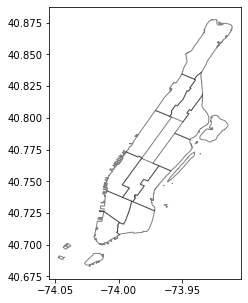

In [2]:
districts = gpd.read_file('dataset/districts')
districts = districts[(districts.boro_cd >= 101.0) & (districts.boro_cd <= 112.0)]
districts = districts.sort_values(by="boro_cd")
districts = districts.reset_index().drop(columns=['index'])
districts.plot(figsize=(5, 5), alpha=0.5, color = 'white', edgecolor='k')

### Assign Number of Plowable Trucks to Each District

* According to "2015-2016 Winter Snow Plan for the Borough of Manhattan" issued by the Department of Sanitation of the City of New York, the number of plowable trucks available in each district is the following
> - District 1: 28 
> - District 2: 33
> - District 3: 26
> - District 4: 26
> - District 5: 29
> - District 6: 38
> - District 7: 43
> - District 8: 49
> - District 9: 27
> - District 10: 19
> - District 11: 18
> - District 12: 36
* According to "Snowplow Operator Driving Time: Survey of State and Local Practices (2016)" issued by the Utah Department of Transportation Research Division, there is a __11-hour driving limit__ rule currently in effect for property-carrying drivers. Snow Plow Operators may drive maximum of 11 hours after 10 consecutive hours.
* Thus, considering there are 24 hours a day, I will assume that the number of snow plow trucks available each shift is __(number of total plow trucks / 2)__

In [3]:
districts['boro_cd'].replace({
    101.0: 1, #District 1
    102.0: 2, #District 2
    103.0: 3, #District 3
    104.0: 4, #District 4
    105.0: 5, #District 5
    106.0: 6, #District 6
    107.0: 7, #District 7
    108.0: 8, #District 8
    109.0: 9, #District 9
    110.0: 10, #District 10
    111.0: 11, #District 11
    112.0: 12 #District 12
}, inplace=True)

In [4]:
truck = {
    1: int(28/2),
    2: int(33/2),
    3: int(26/2),
    4: int(26/2),
    5: int(29/2),
    6: int(38/2),
    7: int(43/2),
    8: int(49/2),
    9: int(27/2),
    10: int(19/2),
    11: int(18/2),
    12: int(36/2)
}
districts['plowable_trucks'] = districts['boro_cd'].map(truck)

In [5]:
districts

,boro_cd,shape_area,shape_leng,geometry,plowable_trucks
0,1.0,4.268800e+07,73996.578231,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",14
1,2.0,3.768921e+07,34130.595861,"POLYGON ((-73.99684 40.73736, -73.99362 40.736...",16
2,3.0,4.687970e+07,30468.340685,"POLYGON ((-73.98878 40.73397, -73.98718 40.733...",13
3,4.0,4.931179e+07,67623.946684,"POLYGON ((-73.99394 40.77318, -73.99370 40.773...",13
4,5.0,4.379030e+07,35288.305355,"POLYGON ((-73.97301 40.76428, -73.97141 40.763...",14
5,6.0,3.873269e+07,43036.085641,"MULTIPOLYGON (((-73.96128 40.73016, -73.96128 ...",19
6,7.0,5.315282e+07,39863.701628,"POLYGON ((-73.95965 40.80116, -73.95848 40.800...",21
7,8.0,5.517244e+07,53927.099117,"MULTIPOLYGON (((-73.93557 40.77192, -73.93566 ...",24
8,9.0,4.189218e+07,34959.184559,"POLYGON ((-73.94014 40.83037, -73.93963 40.830...",13
9,10.0,3.908463e+07,35825.290525,"POLYGON ((-73.93445 40.83598, -73.93456 40.835...",9


# NYC Wi-fi Hotspot Data

* Visualization for inspecting datasets will be done using folium
* Visualization for actual analysis will be done using GeoPandas

In [6]:
df_wifi = pd.read_csv("dataset/nyc-wi-fi-hotspot-locations.csv")
df_wifi = df_wifi[df_wifi.Borough=='MN']
df_wifi['ID'] = [ 1 for i in range(len(df_wifi))] #created ID to identify which dataset each row belongs to
df_wifi = df_wifi[['Latitude','Longitude','ID']]
df_wifi = df_wifi[(df_wifi['Latitude']>40.695834)&(df_wifi['Longitude']>-74.015491)] #Exclude Governors Island
list_wifi = df_wifi[['Latitude','Longitude']].values.tolist()

In [7]:
nyc_map_1 = folium.Map(location=[40.75,-73.98], tiles='Stamen Toner', zoom_start=13)
for loc in list_wifi:
    folium.CircleMarker(loc, radius=6, color='green', fill=False, opacity=0.4).add_to(nyc_map_1)
nyc_map_1

### Transportation Data

In [8]:
df_mta = pd.read_csv('dataset/MTA_StationLocations.csv')
df_mta = df_mta[df_mta['Borough']=="M"]
df_mta['ID'] = [ 2 for i in range(len(df_mta))] #created ID to identify which dataset each row belongs to
df_mta = df_mta[['GTFS Latitude','GTFS Longitude','ID']]
df_mta = df_mta.rename(columns={"GTFS Latitude": "Latitude", "GTFS Longitude": "Longitude"})
list_mta = df_mta[['Latitude','Longitude']].values.tolist()

In [9]:
df_mta.head(1)

,Latitude,Longitude,ID
6,40.76266,-73.967258,2


In [10]:
nyc_map_2 = folium.Map(location=[40.75,-73.98], tiles='Stamen Toner', zoom_start=13)
for loc in list_mta:
    folium.CircleMarker(loc, radius=6, color='blue', fill=False, opacity=0.4).add_to(nyc_map_2)
nyc_map_2

### NYC Vehicle Collision Dataset

* NYC Vehicle Collision Dataset contains every single incident record since the year of 2015. Therefore, I randomly sampled 500 incidents, since there is no strong seasonal variation for street traffic.

In [11]:
df_collision = pd.read_csv("dataset/vehicle_collision.csv")
df_collision = df_collision[df_collision.BOROUGH == 'MANHATTAN']
df_collision.reset_index(inplace=True)
df_collision['ID'] = [ 3 for i in range(len(df_collision))] #created ID to identify which dataset each row belongs to
df_collision = df_collision.loc[:,['LATITUDE','LONGITUDE','ID']]
df_collision = df_collision.rename(columns={"LATITUDE": "Latitude", "LONGITUDE": "Longitude"})
df_collision = df_collision.sample(n=500, replace=False)
list_collision = df_collision[['Latitude','Longitude']].dropna().values.tolist()

In [12]:
nyc_map_3 = folium.Map(location=[40.75,-73.98], tiles='Stamen Toner', zoom_start=13)
for i in list_collision:
    folium.CircleMarker(i, radius=6, color='red', fill=False, opacity=0.4).add_to(nyc_map_3)
nyc_map_3

### Converting Data Coordinates into objects analyzable with GeoPandas

In [13]:
df_wifi['Coordinate'] = df_wifi.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)
df_mta['Coordinate'] = df_mta.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)
df_collision['Coordinate'] = df_collision.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)
geo_wifi = gpd.GeoDataFrame(df_wifi).set_geometry('Coordinate')
geo_mta = gpd.GeoDataFrame(df_mta).set_geometry('Coordinate')
geo_collision = gpd.GeoDataFrame(df_collision).set_geometry('Coordinate')

* This is how all data points look like on a GeoPandas plot

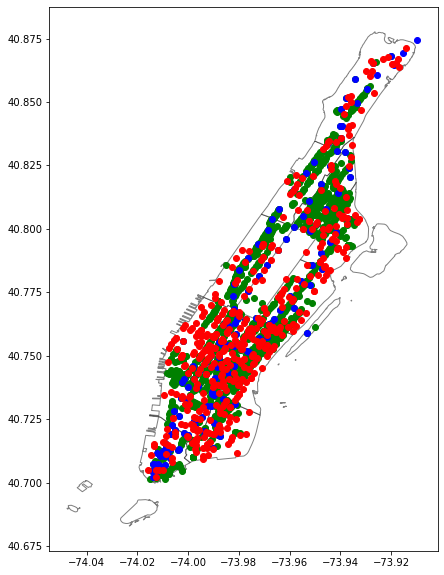

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
districts.plot(ax=ax, color='white', edgecolor='black', alpha=.5)

geo_wifi.plot(ax=ax, color='green')
geo_mta.plot(ax=ax, color='blue')
geo_collision.plot(ax=ax, color='red')

* I will combine all datasets because I have already assigned datapoints IDs telling in which set they belong

In [15]:
geo_combined = pd.concat([geo_wifi, geo_mta, geo_collision])
geo_combined = geo_combined.reset_index()
geo_combined = geo_combined.drop(columns=['index'])

* I will match each datapoint to its geographical district

In [16]:
geo_combined['district_id'] = np.nan
for i in range(len(districts)):
    boundary = districts['geometry'].loc[i]
    for j in geo_combined.index:
        if geo_combined['Coordinate'][j].within(boundary):
            geo_combined.at[j,'district_id']=i+1
        else:
            pass

geo_combined = geo_combined.dropna()
print(geo_combined)

       Latitude  Longitude  ID                  Coordinate  district_id
0     40.719789 -73.981466   1  POINT (-73.98147 40.71979)          3.0
1     40.720005 -73.981438   1  POINT (-73.98144 40.72001)          3.0
2     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
3     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
4     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
5     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
6     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
7     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
8     40.812681 -73.939357   1  POINT (-73.93936 40.81268)         10.0
9     40.846889 -73.941333   1  POINT (-73.94133 40.84689)         12.0
10    40.846472 -73.941722   1  POINT (-73.94172 40.84647)         12.0
11    40.846200 -73.941347   1  POINT (-73.94135 40.84620)         12.0
12    40.846444 -73.939981   1  POINT (-73.93998 40.84644)      

### Choose Potential Truck Locations & Assign Weight

* The following is the standard I used when weighing datapoints from different datasets
* Also, IDs are assigned in correlation with the weight allocated
> __Weight 3__
> * Vehicle Collision: these are records demonstrating tangible evidence for potential risk
> ----
> __Weight 2__
> * Transportation Locations: these are records directly showing high population density. There are always many people near MTA stations.
> ----
> __Weight 1__
> * Wi-fi Locations: these are records indirectly showing high population density. There may or may not be many people around wi-fi locations, but intuitively many wi-fi locations imply high population density.
* According to the weight standard, I will choose potential truck locations from the vehicle collision dataset.

In [17]:
num_potential_loc = districts['plowable_trucks'].sum()
potential_loc = geo_combined[geo_combined['ID']==3].iloc[rd.sample(range(len(geo_combined[geo_combined['ID']==3])),num_potential_loc)]['Coordinate']

* I will make 2 lists
> * Number of datapoints covered by each location
> * Datapoint Weight

In [18]:
potential_loc_list = [(potential_loc.values[i].y,potential_loc.values[i].x) for i in range(num_potential_loc)]
geo_combined_list = [(geo_combined.Coordinate.values[i].y,geo_combined.Coordinate.values[i].x) for i in range(len(geo_combined))]

In [19]:
distance = 0.3

locs = [set([j for j,loc in enumerate(potential_loc_list) 
          if great_circle(loc,geo_combined_list).km < distance])
          for i,geo_combined_list in enumerate(geo_combined_list)]

In [20]:
weight = geo_combined['ID'].values.tolist()

### Create & Run Gurobi Optimization Model

In [21]:
P = num_potential_loc

model = Model('NYC Snow Plow Truck Allocation')
model.setParam('TimeLimit', 60)

# Decision variables
print('creating vars')
truck_locations = model.addVars(range(num_potential_loc),name='x',vtype=GRB.BINARY)
datapoint_locations = model.addVars(range(len(geo_combined_list)),name='y',vtype=GRB.BINARY)

# Constraints
print('creating cons')
model.addConstrs((sum([truck_locations[j] for j in locs[i]]) >= datapoint_locations[i] \
                  for i in range(len(geo_combined_list))),'coverage')
model.addConstr((sum([truck_locations[j] for j in range(num_potential_loc)]) == P),'capacity')

print('setting obj')
model.setObjective(sum([weight[i]*datapoint_locations[i] for i in range(len(geo_combined_list))]),GRB.MAXIMIZE)

print('solving')
model.optimize()

Academic license - for non-commercial use only
Changed value of parameter TimeLimit to 60.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
creating vars
creating cons
setting obj
solving
Optimize a model with 2157 rows, 2339 columns and 5472 nonzeros
Variable types: 0 continuous, 2339 integer (2339 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 2e+02]
Found heuristic solution: objective 2361.0000000
Presolve removed 2157 rows and 2339 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.05 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 2361 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.361000000000e+03, best bound 2.361000000000e+03, gap 0.0000%


In [22]:
selected_locs = []
for v in model.getVars():
    if v.x != 0:
        if v.varName[0] == 'x':
            j = int(v.varName[2:-1])
            selected_locs.append(Point(potential_loc_list[j][1],potential_loc_list[j][0])) # (long,lat)

### Create Visualization of the Optimizaed Locations

Text(0.5, 1, 'NYC Snow Plow Truck Allocation')

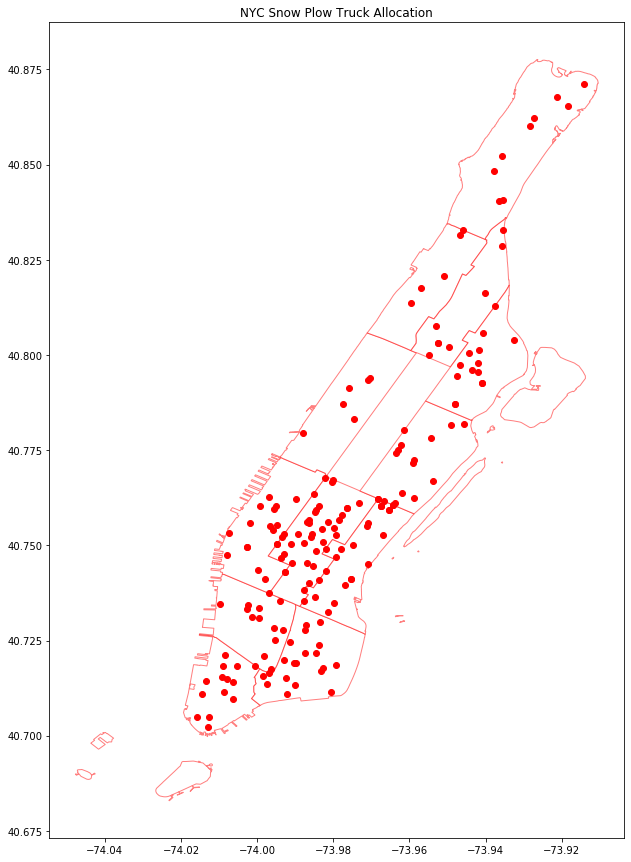

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
districts.plot(ax=ax, color='white', edgecolor='red', alpha=.5)
solution_locs = gpd.GeoDataFrame(selected_locs,columns=['geometry'])
solution_locs.plot(ax=ax, color='red')
ax.set_title('NYC Snow Plow Truck Allocation')

### Create & Run Weighted KMeans Model

* First, since all data are lat-lon pairs, we need to amend the types in order to correctly visualize the results of KMeans Clustering

In [24]:
geo_wifi_w = geo_wifi.iloc[np.repeat(np.arange(len(geo_wifi)), 100)]
geo_mta_w = geo_mta.iloc[np.repeat(np.arange(len(geo_mta)), 200)]
geo_collision_w = geo_collision.iloc[np.repeat(np.arange(len(geo_collision)), 300)]
geo_combined = pd.concat([geo_wifi_w, geo_mta_w, geo_collision_w])
geo_combined = geo_combined.reset_index()
geo_combined = geo_combined.drop(columns=['index'])
geo_combined = geo_combined.dropna()

In [25]:
geo_kmeans = gpd.GeoDataFrame(geo_combined['Coordinate']).set_geometry('Coordinate')
geo_kmeans.crs = {'init': 'epsg:4326'}
geo_kmeans = geo_kmeans.to_crs(epsg=3435)
geo_kmeans = pd.DataFrame(geo_kmeans)
geo_kmeans[:5]

,Coordinate
0,POINT (4968414.358 1805378.721)
1,POINT (4968414.358 1805378.721)
2,POINT (4968414.358 1805378.721)
3,POINT (4968414.358 1805378.721)
4,POINT (4968414.358 1805378.721)


In [26]:
array = []
for i in geo_kmeans['Coordinate']:
    array.append([i.x, i.y])
datapoints = np.array(array)
datapoints[:5]

array([[4968414.35829582, 1805378.72127486],
       [4968414.35829582, 1805378.72127486],
       [4968414.35829582, 1805378.72127486],
       [4968414.35829582, 1805378.72127486],
       [4968414.35829582, 1805378.72127486]])

In [27]:
clusters = KMeans(n_clusters=num_potential_loc).fit(datapoints).cluster_centers_
centroids = gpd.GeoDataFrame([Point(x,y) for x,y in clusters],columns=['geometry'])
centroids.head()

,geometry
0,POINT (4969595.359 1843017.669)
1,POINT (4963614.475 1813300.932)
2,POINT (4969924.404 1821162.261)
3,POINT (4963900.194 1805320.792)
4,POINT (4973032.837 1858521.770)


In [28]:
centroids.crs = {'init' : 'epsg:3435'}
centroids = centroids.to_crs(epsg=4326)
centroids.head()

,geometry
0,POINT (-73.95532 40.81934)
1,POINT (-73.99362 40.74298)
2,POINT (-73.96697 40.76108)
3,POINT (-73.99728 40.72164)
4,POINT (-73.93418 40.85902)


Text(0.5, 1, 'NYC Snow Plow Truck Allocation')

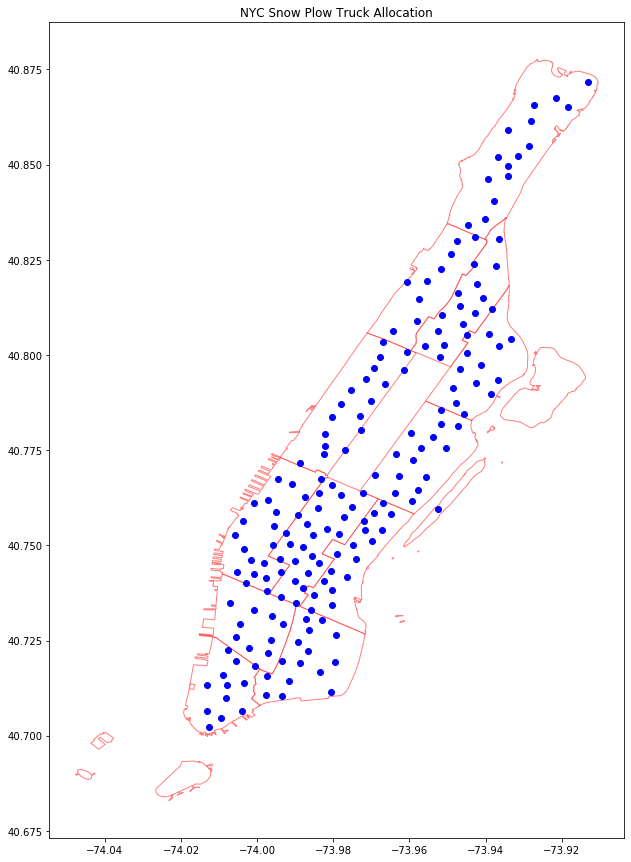

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
districts.plot(ax=ax, color='white', edgecolor='red', alpha=.5)
centroids.plot(ax=ax, color='blue')
ax.set_title('NYC Snow Plow Truck Allocation')

### Compare Gurobi vs KMeans

> * Gurobi: Red
> * KMeans: Blue

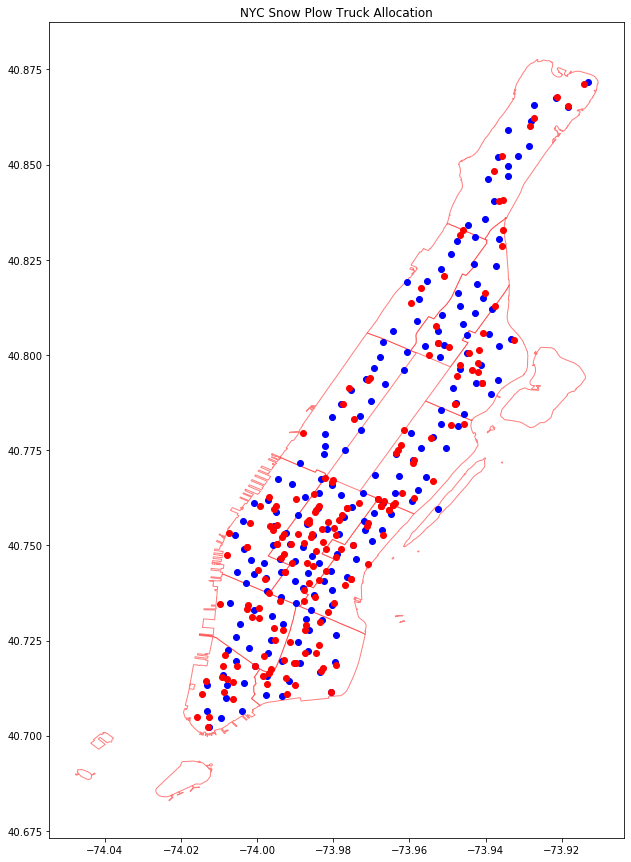

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
districts.plot(ax=ax, color='white', edgecolor='red', alpha=.5)
centroids.plot(ax=ax, color='blue')
ax.set_title('NYC Snow Plow Truck Allocation')
solution_locs.plot(ax=ax, color='red')